# Neuroevolution on EvoGym

## Getting started

Check that the following line can run. If so, you have evogym installed! Otherwise, you need to install it.

In [2]:
from evogym import sample_robot
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import copy
import matplotlib.pyplot as plt
from matplotlib import animation
import gymnasium as gym

import evogym.envs
from evogym import sample_robot
from evogym.utils import get_full_connectivity
from tqdm import tqdm

## Agent

In [3]:
class Network(nn.Module):
    def __init__(self, n_in, h_size, n_out):
        super().__init__()
        self.fc1 = nn.Linear(n_in, h_size)
        self.fc2 = nn.Linear(h_size, h_size)
        self.fc3 = nn.Linear(h_size, n_out)
 
        self.n_out = n_out

    def reset(self):
        pass
    
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)
        x = F.relu(x)

        x = self.fc3(x)
        return x

In [4]:
class Agent:
    def __init__(self, Net, config, genes = None):
        self.config = config
        self.Net = Net
        self.model = None
        self.fitness = None

        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu")

        self.make_network()
        if genes is not None:
            self.genes = genes

    def __repr__(self):  # pragma: no cover
        return f"Agent {self.model} > fitness={self.fitness}"

    def __str__(self):  # pragma: no cover
        return self.__repr__()

    def make_network(self):
        n_in = self.config["n_in"]
        h_size = self.config["h_size"]
        n_out = self.config["n_out"]
        self.model = self.Net(n_in, h_size, n_out).to(self.device).double()
        return self

    @property
    def genes(self):
        if self.model is None:
            return None
        with torch.no_grad():
            params = self.model.parameters()
            vec = torch.nn.utils.parameters_to_vector(params)
        return vec.cpu().double().numpy()

    @genes.setter
    def genes(self, params):
        if self.model is None:
            self.make_network()
        assert len(params) == len(
            self.genes), "Genome size does not fit the network size"
        if np.isnan(params).any():
            raise
        a = torch.tensor(params, device=self.device)
        torch.nn.utils.vector_to_parameters(a, self.model.parameters())
        self.model = self.model.to(self.device).double()
        self.fitness = None
        return self

    def mutate_ga(self):
        genes = self.genes
        n = len(genes)
        f = np.random.choice([False, True], size=n, p=[1/n, 1-1/n])
        
        new_genes = np.empty(n)
        new_genes[f] = genes[f]
        noise = np.random.randn(n-sum(f))
        new_genes[~f] = noise
        return new_genes

    def act(self, obs):
        # continuous actions
        with torch.no_grad():
            x = torch.tensor(obs).double().unsqueeze(0).to(self.device)
            actions = self.model(x).cpu().detach().numpy()
        return actions


## Environment

In [5]:
walker = np.array([
    [3, 3, 3, 3, 3],
    [3, 3, 3, 0, 3],
    [3, 3, 0, 3, 3],
    [3, 3, 0, 3, 3],
    [3, 3, 0, 3, 3]
    ])

In [6]:
def make_env(env_name, seed=None, robot=None, **kwargs):
    if robot is None: 
        env = gym.make(env_name)
    else:
        connections = get_full_connectivity(robot)
        env = gym.make(env_name, body=robot)
    env.robot = robot
    if seed is not None:
        env.seed(seed)
        
    return env

In [7]:
def evaluate(agent, env, max_steps=500, render=False):
    obs, i = env.reset()
    agent.model.reset()
    reward = 0
    steps = 0
    done = False
    while not done and steps < max_steps:
        if render:
            env.render()
        action = agent.act(obs)
        obs, r, done, trunc, _ = env.step(action)
        reward += r
        steps += 1
    return reward

In [8]:
def get_cfg(env_name, robot=None):
    env = make_env(env_name, robot=walker)
    cfg = {
        "n_in": env.observation_space.shape[0],
        "h_size": 32,
        "n_out": env.action_space.shape[0],
    }
    env.close()
    return cfg

In [9]:
env_name = 'Walker-v0'
robot = walker

cfg = get_cfg(env_name, robot)
a = Agent(Network, cfg)
a

Using Evolution Gym Simulator v2.2.5


Agent Network(
  (fc1): Linear(in_features=76, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=21, bias=True)
) > fitness=None

In [10]:
env = make_env(env_name, robot=walker)
s = env.reset()
len(s), s

(2,
 (array([ 0.        ,  0.        , -0.25135135, -0.15135135, -0.25135135,
         -0.15135135, -0.05135135, -0.05135135,  0.04864865,  0.04864865,
          0.14864865,  0.14864865,  0.24864865,  0.24864865, -0.25135135,
         -0.15135135, -0.05135135,  0.04864865,  0.14864865,  0.24864865,
         -0.25135135, -0.15135135, -0.05135135,  0.04864865,  0.04864865,
          0.14864865,  0.24864865, -0.25135135, -0.15135135, -0.05135135,
          0.04864865,  0.14864865,  0.24864865, -0.25135135, -0.15135135,
         -0.05135135,  0.04864865,  0.14864865,  0.24864865,  0.24864865,
          0.24864865,  0.14864865,  0.14864865,  0.24864865,  0.14864865,
          0.24864865,  0.14864865,  0.24864865,  0.14864865,  0.24864865,
          0.14864865,  0.04864865,  0.04864865,  0.04864865,  0.04864865,
          0.04864865,  0.04864865, -0.05135135, -0.05135135, -0.05135135,
          0.04864865, -0.05135135, -0.05135135, -0.05135135, -0.15135135,
         -0.15135135, -0.15135135,

In [11]:
# Evaluation
env = make_env(env_name, robot=walker)
reward = evaluate(a, env, render=True)
print(f"Reward: {reward}")
env.close()

/Users/massimodebellisvitti/Desktop/Algorithme evolutionnaire/evolution/.venv/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:334: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


Reward: 0.013197669837007653


In [12]:
def mp_eval(a, cfg):
    env = make_env(cfg["env_name"], robot=cfg["robot"])
    fit = evaluate(a, env, max_steps=cfg["max_steps"])
    env.close()
    return fit

## Algorithms
### 1+$\lambda$ EA

In [13]:
def one_plus_lambda(config):
    cfg = get_cfg(config["env_name"], robot=config["robot"]) # Get network dims
    cfg = {**config, **cfg} # Merge configs
    
    env = make_env(cfg["env_name"], robot=cfg["robot"])

    # Elite
    elite = Agent(Network, cfg)

    elite.fitness = evaluate(elite, env, max_steps=cfg["max_steps"])

    fits = []
    total_evals = []

    bar = tqdm(range(cfg["generations"]))
    for gen in bar:
        population = [Agent(Network, cfg, genes=elite.mutate_ga()) 
            for _ in range(cfg["lambda"])]

        # with Pool(processes=len(population)) as pool:
            # pop_fitness = pool.starmap(mp_eval, [(a, cfg) for a in population])

        pop_fitness = [evaluate(a, env, max_steps=cfg["max_steps"]) for a in population]

        best = np.argmax(pop_fitness)
        best_fit = pop_fitness[best]
        if best_fit > elite.fitness:
            elite.genes = population[best].genes
            elite.fitness = best_fit
        fits.append(elite.fitness)
        total_evals.append(len(population) * (gen+1))
        bar.set_description(f"Best: {elite.fitness}")
        
    env.close()
    plt.plot(total_evals, fits)
    plt.xlabel("Evaluations")
    plt.ylabel("Fitness")
    plt.show()
    return elite

Best: 0.009817186029748848: 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]


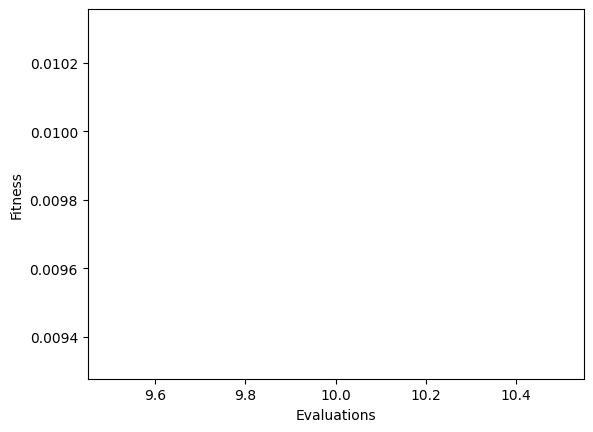

In [15]:
config = {
    "env_name": "Walker-v0",
    "robot": walker,
    "generations": 1, # To change: increase!
    "lambda": 10,
    "max_steps": 100, # to change to 500
}

a = one_plus_lambda(config)
a.fitness

cfg = get_cfg(config["env_name"], robot=config["robot"]) # Get network dims
cfg = {**config, **cfg} # Merge configs


In [ ]:
env = make_env(config["env_name"], robot=config["robot"])
evaluate(a, env, render=False)
env.close()

### Evolution Strategy

In [16]:
def ES(config):
    cfg = get_cfg(config["env_name"], robot=config["robot"]) # Get network dims
    cfg = {**config, **cfg} # Merge configs
    
    # Update weights
    mu = cfg["mu"]
    w = np.array([np.log(mu + 0.5) - np.log(i)
                          for i in range(1, mu + 1)])
    w /= np.sum(w)
    
    env = make_env(cfg["env_name"], robot=cfg["robot"])

    # Center of the distribution
    elite = Agent(Network, cfg)
    elite.fitness = -np.inf
    theta = elite.genes
    d = len(theta)

    fits = []
    total_evals = []

    bar = tqdm(range(cfg["generations"]))
    for gen in bar:
        population = []
        for i in range(cfg["lambda"]):
            genes = theta + np.random.randn(len(theta)) * cfg["sigma"]
            ind = Agent(Network, cfg, genes=genes)
            # ind.fitness = evaluate(ind, env, max_steps=cfg["max_steps"])
            population.append(ind)

        # with Pool(processes=len(population)) as pool:
        #     pop_fitness = pool.starmap(mp_eval, [(a, cfg) for a in population])
        
        pop_fitness = [evaluate(a, env, max_steps=cfg["max_steps"]) for a in population]
        
        for i in range(len(population)):
            population[i].fitness = pop_fitness[i]

        # sort by fitness
        inv_fitnesses = [- f for f in pop_fitness]
        # indices from highest fitness to lowest
        idx = np.argsort(inv_fitnesses)
        
        step = np.zeros(d)
        for i in range(mu):
            # update step
            step = step + w[i] * (population[idx[i]].genes - theta)
        # update theta
        theta = theta + step * cfg["lr"]

        if pop_fitness[idx[0]] > elite.fitness:
            elite.genes = population[idx[0]].genes
            elite.fitness = pop_fitness[idx[0]]

        fits.append(elite.fitness)
        total_evals.append(len(population) * (gen+1))

        bar.set_description(f"Best: {elite.fitness}")
        
    env.close()
    plt.plot(total_evals, fits)
    plt.xlabel("Evaluations")
    plt.ylabel("Fitness")
    plt.show()
    return elite

Best: 0.017286355197959347: 100%|██████████| 10/10 [00:16<00:00,  1.60s/it]


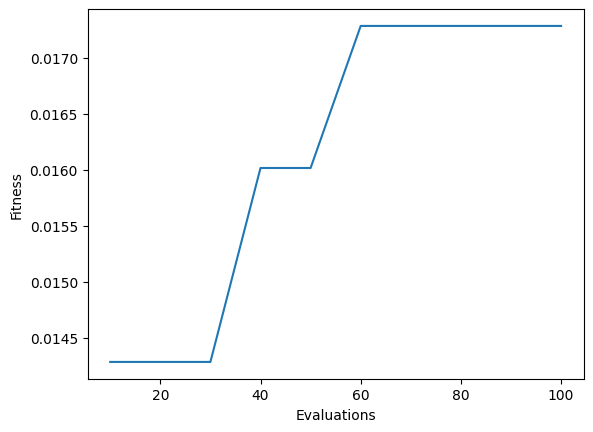

In [ ]:
config = {
    "env_name": "Walker-v0",
    "robot": walker,
    "generations": 10, # to change: increase!
    "lambda": 10, # Population size
    "mu": 5, # Parents pop size
    "sigma": 0.1, # mutation std
    "lr": 1, # Learning rate
    "max_steps": 100, # to change to 500
}

a = ES(config)
a.fitness

cfg = get_cfg(config["env_name"], robot=config["robot"]) # Get network dims
cfg = {**config, **cfg} # Merge configs

In [ ]:
env = make_env(config["env_name"], robot=config["robot"])
evaluate(a, env, render=False)
env.close()

In [ ]:
np.save("Walker.npy", a.genes)

## Pre-trained walker

In [ ]:
# load weights

config = {
    "env_name": "Walker-v0",
    "robot": walker,
    "generations": 10,
    "lambda": 10, # Population size
    "mu": 5, # Parents pop size
    "sigma": 0.1, # mutation std
    "lr": 1, # Learning rate
    "max_steps": 500,
}

cfg = get_cfg(config["env_name"], robot=config["robot"]) # Get network dims
cfg = {**config, **cfg} # Merge configs
a = Agent(Network, cfg)
a.genes = np.load("Walker.npy")

In [ ]:
env = make_env(cfg["env_name"], robot=cfg["robot"])
a.fitness = evaluate(a, env, render=False)
env.close()
print(a.fitness)

0.032897863648989334


Salva soluzione

In [18]:
import json
def save_solution(a, cfg, name="solution.json"):
    save_cfg = {}
    for i in ["env_name", "robot", "n_in", "h_size", "n_out"]:
        assert i in cfg, f"{i} not in config"
        save_cfg[i] = cfg[i]
    save_cfg["robot"] = cfg["robot"].tolist()
    save_cfg["genes"] = a.genes.tolist()
    save_cfg["fitness"] = float(a.fitness)
    # save
    with open(name, "w") as f:
        json.dump(save_cfg, f)
    return save_cfg

In [ ]:
save_solution(a, cfg)

{'env_name': 'Walker-v0',
 'robot': [[3, 3, 3, 3, 3],
  [3, 3, 3, 0, 3],
  [3, 3, 0, 1, 1],
  [3, 3, 0, 1, 2],
  [3, 3, 0, 3, 3]],
 'n_in': 76,
 'h_size': 32,
 'n_out': 17,
 'genes': [0.47762727530280463,
  -0.05070660039638386,
  0.28520795076229183,
  -0.04257965609058376,
  0.1846543587067559,
  -0.3575412464262521,
  0.44415017590855305,
  -0.13754695013461418,
  0.27736296015949136,
  -0.2943111318035697,
  0.21993570054291783,
  -0.05008384899992582,
  -0.04214248467447394,
  0.11358210445749124,
  -0.05226159861131065,
  -0.05260615978235124,
  0.28022792869643487,
  0.06520514628329505,
  -0.28998688505711706,
  -0.15480702775511418,
  0.12901370892693265,
  -0.2779740651913555,
  -0.10301185530724147,
  0.04589476316126222,
  0.10816048648801604,
  0.1293845713829639,
  0.08532720738947483,
  -0.03142600256347339,
  0.23953830412989774,
  -0.33785856577876533,
  -0.17033874262131704,
  -0.13741193470706034,
  -0.08259971618108002,
  -0.007077058939688963,
  0.23083855963743266

In [ ]:
def load_solution(name="solution.json"):
    with open(name, "r") as f:
        cfg = json.load(f)
    cfg["robot"] = np.array(cfg["robot"])
    cfg["genes"] = np.array(cfg["genes"])
    a = Agent(Network, cfg, genes=cfg["genes"])
    a.fitness = cfg["fitness"]
    return a

In [ ]:
a = load_solution(name="solution.json")
cfg = a.config
env = make_env(cfg["env_name"], robot=cfg["robot"])
a.fitness = evaluate(a, env, render=False)
env.close()
print(a.fitness)

0.5044560581209562


In [ ]:
walker = np.array([
    [3, 3, 0, 3, 0 ],
    [3, 0, 3, 3, 3],
    [0, 2, 3, 1, 0],
    [2, 3, 3, 1, 1],
    [3, 3, 0, 3, 3]
    ])

np.save("walker_matrix.npy", walker)

config = {
    "env_name": "Walker-v0",
    "robot": walker,
    "generations": 1, # to change: increase!
    "lambda": 10, # Population size
    "mu": 5, # Parents pop size
    "sigma": 0.1, # mutation std
    "lr": 1, # Learning rate
    "max_steps": 100, # to change to 500
}

a = ES(config)
a.fitness

cfg = get_cfg(config["env_name"], robot=config["robot"]) # Get network dims
cfg = {**config, **cfg} # Merge configs

env = make_env(config["env_name"], robot=config["robot"])
evaluate(a, env, render=False)
env.close()

np.save("Walker.npy", a.genes)

save_solution(a, cfg)

In [ ]:
save_solution(a, cfg)

{'env_name': 'Walker-v0',
 'robot': [[3, 3, 3, 3, 3],
  [3, 3, 3, 0, 3],
  [3, 3, 0, 1, 1],
  [3, 3, 0, 1, 2],
  [3, 3, 0, 3, 3]],
 'n_in': 76,
 'h_size': 32,
 'n_out': 17,
 'genes': [-0.41892823719351335,
  -0.4081323631285263,
  0.18371289107737487,
  -0.4298423091465507,
  -1.3511844378899567,
  -0.14917926374940305,
  0.42510085911867734,
  1.0325883240541016,
  -0.7181702970346522,
  0.6515181879099153,
  -0.5698252038908681,
  -0.895270741506502,
  -0.7867073856726375,
  -0.07934563914678885,
  -0.3229897085905944,
  0.018217781408810203,
  0.5419018996508803,
  0.35663270399529173,
  0.1965759738714274,
  0.13795202241338397,
  0.6798406692159522,
  -0.13410329868152499,
  0.27470235731402104,
  0.6707554975108152,
  -0.16043895853901566,
  -0.1348671313841723,
  0.21992916750318364,
  -0.06596326580330611,
  0.17372847405935968,
  -0.5336166478352425,
  1.0313948415858998,
  0.8743563496312312,
  0.05377591622789671,
  -0.015394175886729991,
  -0.15322993104318078,
  0.50579926